In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import seaborn
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms

from torch.utils.data import TensorDataset
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import random

In [4]:
class Trainer:

    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: None,
                 # lr_scheduler: torch.optim.lr_scheduler = None,
                 epochs: int = 100,
                 epoch: int = 0,
                 notebook: bool = False,
                 path2write: str = None,
                 save_best=False,
                 save_final=True,
                 save_interval=10,
                 checkpoint_start_epoch=50,
                 gradient_norm = False
                 ):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        # self.lr_scheduler = lr_scheduler
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs
        self.epoch = epoch
        self.notebook = notebook
        self.path2write = path2write
        LOG_DIR = os.path.join(path2write, 'Log')  # path2write + 'Log/'
        self.writer_train = SummaryWriter(os.path.join(LOG_DIR, "train"))
        self.writer_val = SummaryWriter(os.path.join(LOG_DIR, "val"))
        self.check_point_path = os.path.join(path2write, 'check_points')
        if not os.path.exists(self.check_point_path):
            os.makedirs(self.check_point_path)
        self.save_best = save_best
        self.save_final = save_final
        self.save_interval = save_interval
        self.checkpoint_start_epoch = checkpoint_start_epoch
        self.training_loss = []
        self.validation_loss = []
        self.learning_rate = []
        self.gradient_norm = gradient_norm
        self.grad_list = []

    def run_trainer(self):
        self.model.to(self.device)
        #         print(next(self.model.parameters()).device)
        if self.notebook:
            print('Notebook')
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange
        #         print(self.epochs)
        progressbar = trange(self.epochs, desc='Progress', disable=True)  # don't show progressbar
        loss_max = None
        for epoch in progressbar:
            print(f'Epoch - {epoch}')

            # Training Block
            train_loss = self._train()
            self.writer_train.add_scalar("Loss", train_loss, epoch)

            # Val Block
            val_loss = self._validate()
            self.writer_val.add_scalar("Loss", val_loss, epoch)

            # lr
            self.writer_train.add_scalar("Learning Rate", self.optimizer.param_groups[0]['lr'], epoch)

            # print('Epoch - {} Train Loss - {:.6f} Val Loss - {:.6f}'.format(epoch, train_loss, val_loss))
            if self.save_final:
                if epoch == self.epochs-1:
                    model_name = 'epoch-{}-loss{:.6f}'.format(epoch, val_loss)
                    torch.save(self.model.state_dict(), os.path.join(self.check_point_path, model_name))

            loss_max = val_loss

            if self.gradient_norm:
              grad_all = 0.0
              for p in self.model.parameters():
                grad = 0.0
                if p.grad is not None:
                  grad = (p.grad.cpu().data.numpy()**2).sum()
                  grad_all += grad
              self.grad_list.append(grad_all**0.5)

        if self.gradient_norm:
          return self.grad_list, self.training_loss
        return self.training_loss, self.validation_loss, self.model

    def _train(self):

        self.model.train()
        train_losses = []
        batch_iter = tqdm(enumerate(self.training_DataLoader), 'Training', total=len(self.training_DataLoader),
                          disable=True)
        for i, (x, y) in batch_iter:
            input, target = x.type(torch.float32).to(self.device), y.type(torch.float32).to(self.device)
            self.optimizer.zero_grad()
            output = self.model(input)

            loss = self.criterion(output, target)
            train_losses.append(loss.item())
            loss.backward()
            self.optimizer.step()

        self.training_loss.append(np.mean(train_losses))  # Mean batch loss
        self.learning_rate.append(self.optimizer.param_groups[0]['lr'])

        batch_iter.close()  # clean up the bar
        return np.mean(train_losses)

    def _validate(self):

        self.model.eval()
        valid_losses = []
        batch_iter = tqdm(enumerate(self.validation_DataLoader), 'validation', total=len(self.validation_DataLoader),
                          disable=True)
        for i, (x, y) in batch_iter:
            input, target = x.type(torch.float32).to(self.device), y.type(torch.float32).to(self.device)
            with torch.no_grad():
                out = self.model(input)
                loss = self.criterion(target, out)
                valid_losses.append(loss.item())
        self.validation_loss.append(np.mean(valid_losses))
        batch_iter.close()
        return np.mean(valid_losses)

In [5]:
class model1(nn.Module):
    def __init__(self, input_size=1, output_size=1):
        super().__init__()
        self.dense1 = nn.Linear(input_size, 10)
        self.dense2 = nn.Linear(10, 18)
        self.dense3 = nn.Linear(18, 15)
        self.dense4 = nn.Linear(15, 4)
        self.dense5 = nn.Linear(4, output_size)

    def forward(self, input_data):
        x1 = F.relu(self.dense1(input_data))
        x2 = F.relu(self.dense2(x1))
        x3 = F.relu(self.dense3(x2))
        x4 = F.relu(self.dense4(x3))
        x5 = F.relu(self.dense5(x4))
        return x5

In [6]:
def prep_data(func, data_length=2500, train_ratio=0.7, batch_size=8, shuffle=True):
    X = np.linspace(1e-4, 1, data_length)
    # np.random.shuffle(X)
    y = np.array(list(map(func, X)))
    X = X.reshape(X.shape[0], 1)
    y = y.reshape(y.shape[0], 1)
    X = torch.from_numpy(X).float()
    y = torch.from_numpy(y).float()
    X_train, X_val = X[0:int(data_length * train_ratio), ], X[int(data_length * train_ratio):, ]
    y_train, y_val = y[0:int(data_length * train_ratio), ], y[int(data_length * train_ratio):, ]
    assert X_train.shape[0] == y_train.shape[0]
    assert X_val.shape[0] == y_val.shape[0]
    TrainDataLoader = DataLoader(TensorDataset(X_train, y_train), batch_size, shuffle)
    ValDataLoader = DataLoader(TensorDataset(X_val, y_val), batch_size, shuffle)

    return TrainDataLoader, ValDataLoader

In [7]:
path2write = os.path.expanduser("~/my_logs")  # This will create a 'my_logs' directory in your home directory


In [8]:
gpu_id = 0
loss_fn = nn.MSELoss()
lr = 1e-4
func1 = lambda x: (np.sin(5 * (np.pi) * x)) / (5 * np.pi * x)
func2 = lambda x: np.sign(np.sin(5*np.pi*x))
training_DataLoader,  validation_DataLoader = prep_data(func=func1,batch_size=4096)
epochs =  20000
notebook = True
checkpoint_start_epoch = 5 #Not using
path2write = "drive/MyDrive/DL_homework/HW1_1/grad_norm/"

Notebook
Epoch - 0
Epoch - 1
Epoch - 2
Epoch - 3
Epoch - 4
Epoch - 5
Epoch - 6
Epoch - 7
Epoch - 8
Epoch - 9
Epoch - 10
Epoch - 11
Epoch - 12
Epoch - 13
Epoch - 14
Epoch - 15
Epoch - 16
Epoch - 17
Epoch - 18
Epoch - 19
Epoch - 20
Epoch - 21
Epoch - 22
Epoch - 23
Epoch - 24
Epoch - 25
Epoch - 26
Epoch - 27
Epoch - 28
Epoch - 29
Epoch - 30
Epoch - 31
Epoch - 32
Epoch - 33
Epoch - 34
Epoch - 35
Epoch - 36
Epoch - 37
Epoch - 38
Epoch - 39
Epoch - 40
Epoch - 41
Epoch - 42
Epoch - 43
Epoch - 44
Epoch - 45
Epoch - 46
Epoch - 47
Epoch - 48
Epoch - 49
Epoch - 50
Epoch - 51
Epoch - 52
Epoch - 53
Epoch - 54
Epoch - 55
Epoch - 56
Epoch - 57
Epoch - 58
Epoch - 59
Epoch - 60
Epoch - 61
Epoch - 62
Epoch - 63
Epoch - 64
Epoch - 65
Epoch - 66
Epoch - 67
Epoch - 68
Epoch - 69
Epoch - 70
Epoch - 71
Epoch - 72
Epoch - 73
Epoch - 74
Epoch - 75
Epoch - 76
Epoch - 77
Epoch - 78
Epoch - 79
Epoch - 80
Epoch - 81
Epoch - 82
Epoch - 83
Epoch - 84
Epoch - 85
Epoch - 86
Epoch - 87
Epoch - 88
Epoch - 89
Epoch - 90


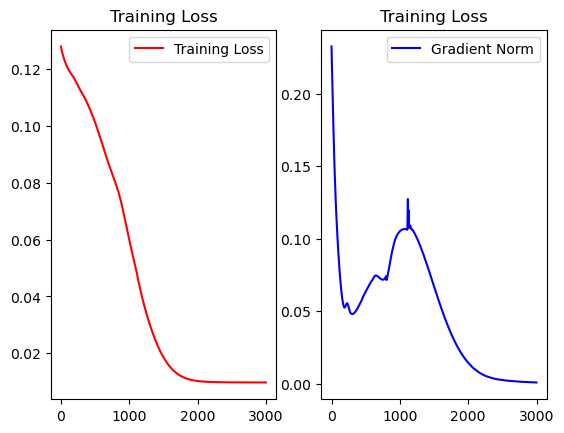

In [9]:
model = model1()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
trainer = Trainer(model=model,
                      device=gpu_id,
                      criterion=loss_fn,
                      optimizer=optimizer,
                      training_DataLoader=training_DataLoader,
                      validation_DataLoader=validation_DataLoader,
                      # lr_scheduler=lr_scheduler,
                      epochs=3000,
                      epoch=0,
                      notebook=True,
                      path2write= path2write,
                      checkpoint_start_epoch=checkpoint_start_epoch,
                      gradient_norm = True)
grad_norm, training_loss = trainer.run_trainer()

fig = plt.figure()

ax1 = fig.add_subplot(1,2,1)
ax1.plot(training_loss, 'r-', label='Training Loss')
ax1.legend()
ax1.set_title('Training Loss')
fig.savefig(os.path.join(path2write, 'Training Loss.png'))

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(grad_norm, 'b-', label='Gradient Norm')
ax2.legend()
ax2.set_title('Training Loss')
fig.savefig(os.path.join(path2write, 'Gradient Norm.png'))

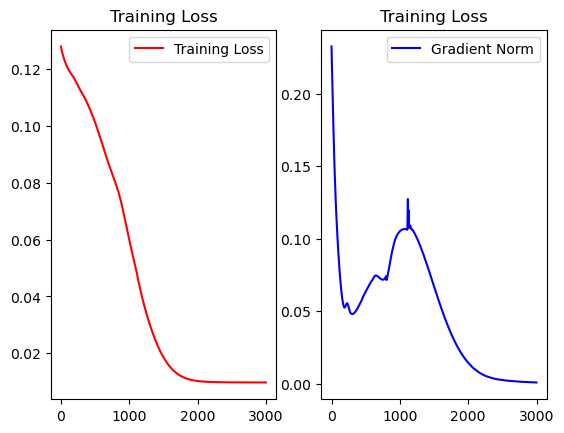

In [11]:
fig = plt.figure()

ax1 = fig.add_subplot(1,2,1)
ax1.plot(training_loss, 'r-', label='Training Loss')
ax1.legend()
ax1.set_title('Training Loss')
fig.savefig(os.path.join(path2write, 'Training Loss.png'))

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(grad_norm, 'b-', label='Gradient Norm')
ax2.legend()
ax2.set_title('Training Loss')
fig.savefig(os.path.join(path2write, 'Gradient Norm.png'))


plt.show()
